#### Step 1 : Data cleaning

prepare the data for machine learning.

- No duplicates
- No NANs
- No text data
- No features that have too strong correlation between them



In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [21]:
df = pd.read_csv(r"C:\Users\32467\OneDrive\Documents\Arai4_Projects\real-estate-price-prediction\assets\data.csv")

In [22]:
df.shape
df.columns

Index(['ID', 'Type', 'SubType', 'Price', 'NetHabitableSurface(msq)',
       'BedroomCount', 'Province', 'Locality', 'Region', 'PostCode', 'Floor',
       'RegionCode', 'BuildingCondition', 'ConstructionYear', 'FacadeCount',
       'HasBalcony', 'HasGarden', 'KitchenType', 'Status'],
      dtype='object')

In [23]:
city = df['PostCode'].apply(lambda x: str(x)[0:2])
df['City']= city
age = df['ConstructionYear'].apply(lambda x: 2022-x)
df['Age'] = age



In [24]:
df.head(5)

,ID,Type,SubType,Price,NetHabitableSurface(msq),BedroomCount,Province,Locality,Region,PostCode,...,RegionCode,BuildingCondition,ConstructionYear,FacadeCount,HasBalcony,HasGarden,KitchenType,Status,City,Age
0,10128188,HOUSE,HOUSE,328330.0,148.0,3.0,Limburg,Zonhoven,Flanders,3520,...,FLANDERS,NaN,NaN,3.0,0.0,1.0,0,0,35,NaN
1,10128189,HOUSE,HOUSE,328330.0,148.0,3.0,Limburg,Zonhoven,Flanders,3520,...,FLANDERS,NaN,NaN,3.0,0.0,1.0,0,0,35,NaN
2,10128190,HOUSE,HOUSE,327829.0,148.0,3.0,Limburg,Zonhoven,Flanders,3520,...,FLANDERS,NaN,NaN,3.0,0.0,1.0,0,0,35,NaN
3,10128191,HOUSE,HOUSE,327829.0,148.0,3.0,Limburg,Zonhoven,Flanders,3520,...,FLANDERS,NaN,NaN,3.0,0.0,1.0,0,0,35,NaN
4,10128192,HOUSE,HOUSE,378242.0,148.0,3.0,Limburg,Zonhoven,Flanders,3520,...,FLANDERS,NaN,NaN,4.0,0.0,1.0,0,0,35,NaN


In [25]:
df.shape

(12813, 21)

In [26]:
df.isna().sum()

ID                             0
Type                           0
SubType                        0
Price                          0
NetHabitableSurface(msq)       0
BedroomCount                   0
Province                       0
Locality                       0
Region                         0
PostCode                       0
Floor                          0
RegionCode                     0
BuildingCondition           3952
ConstructionYear            5264
FacadeCount                    0
HasBalcony                     0
HasGarden                      0
KitchenType                    0
Status                         0
City                           0
Age                         5264
dtype: int64

In [27]:
# drop features with many nan values, higher correlations and has less impact on the price
df = df.drop(['BuildingCondition','ConstructionYear','RegionCode','Locality','ID','Age','City','Floor','HasBalcony','HasGarden'], axis =1)

In [28]:
df.columns

Index(['Type', 'SubType', 'Price', 'NetHabitableSurface(msq)', 'BedroomCount',
       'Province', 'Region', 'PostCode', 'FacadeCount', 'KitchenType',
       'Status'],
      dtype='object')

In [29]:
grouped = df.groupby(df.Type)
df_house = grouped.get_group("HOUSE").drop(['Type'],axis =1)
df_apartment = grouped.get_group("APARTMENT").drop(['Type'],axis =1)

In [30]:
df_apartment.head()

,SubType,Price,NetHabitableSurface(msq),BedroomCount,Province,Region,PostCode,FacadeCount,KitchenType,Status
6,APARTMENT,249000.0,145.0,2.0,Liège,Wallonie,4400,3.0,0,1
7,PENTHOUSE,249000.0,135.0,2.0,Liège,Wallonie,4400,3.0,0,1
9,APARTMENT,350000.0,65.0,1.0,Brussels,Brussels,1000,2.0,3,1
12,APARTMENT,390000.0,165.0,3.0,Antwerp,Flanders,2018,2.0,3,0
13,FLAT_STUDIO,177500.0,26.0,1.0,Brussels,Brussels,1000,2.0,0,0


In [31]:
df_apartment.isna().sum()

SubType                     0
Price                       0
NetHabitableSurface(msq)    0
BedroomCount                0
Province                    0
Region                      0
PostCode                    0
FacadeCount                 0
KitchenType                 0
Status                      0
dtype: int64

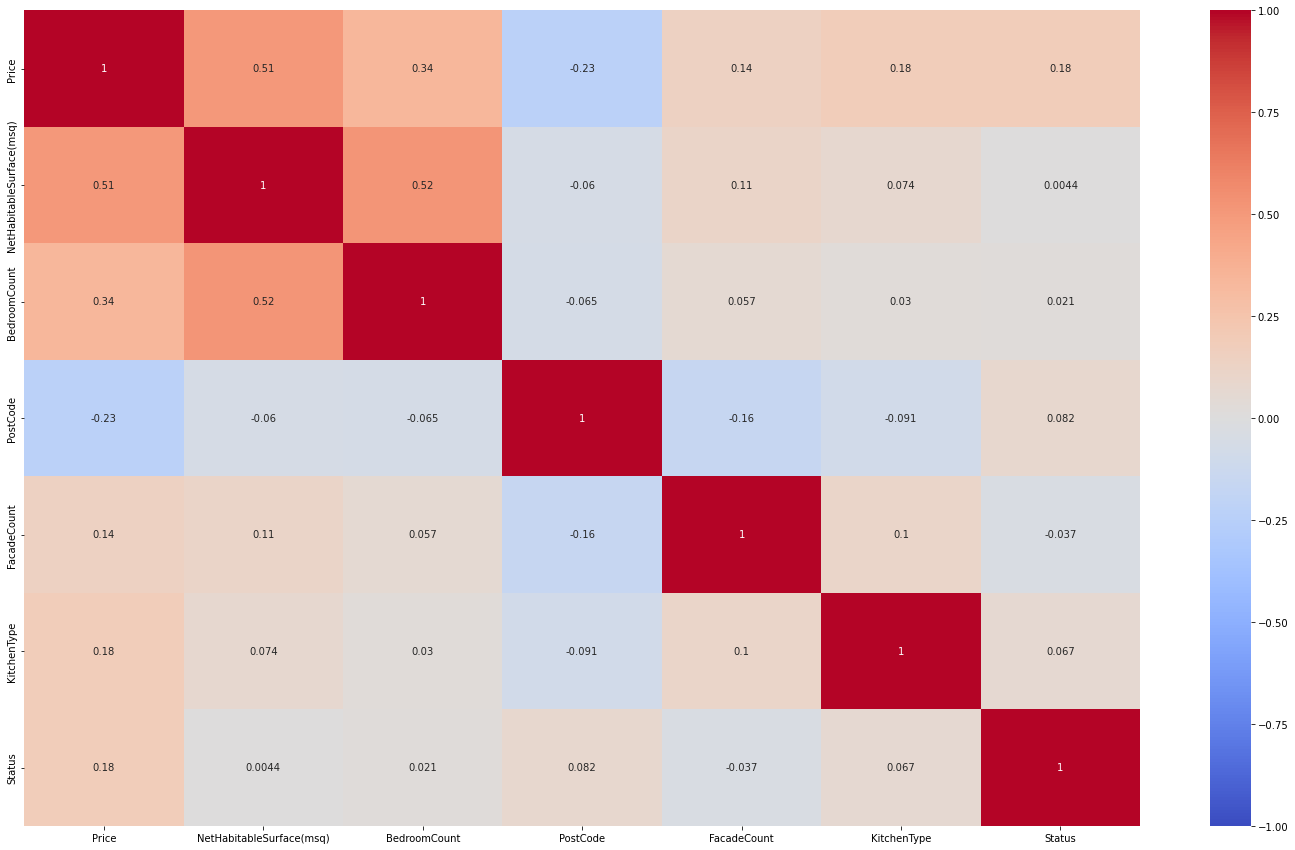

In [32]:
plt.figure(figsize=(25, 15))
sns.heatmap(df_house.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

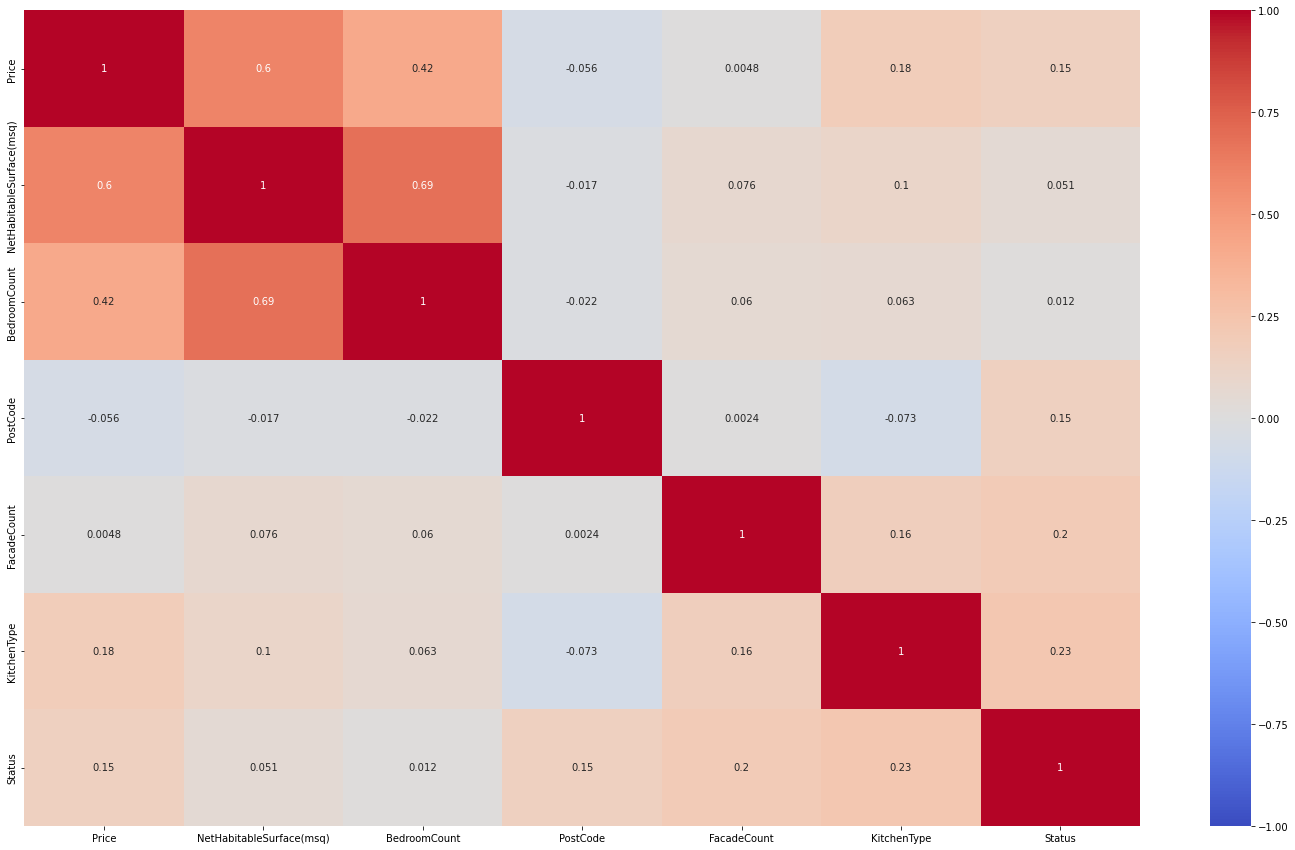

In [33]:
plt.figure(figsize=(25, 15))
sns.heatmap(df_apartment.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

####  Step 2: Data formatting
- Divide dataset for training and testing. (`X_train`, `y_train`, `X_test`, `y_test`)


In [34]:
def get_data(data):
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import StandardScaler

    from sklearn.model_selection import train_test_split
    y= data['Price'].copy().to_numpy()
    X = data.drop('Price', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/5,random_state=0) 
    num_attribs = ['NetHabitableSurface(msq)','BedroomCount']
    cat_attribs = ['Region','Province','SubType','KitchenType','FacadeCount','PostCode']

    num_tr_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
    
    cat_tr_pipeline = Pipeline([
        ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
        
    ])
    

    full_pipeline = ColumnTransformer([
        ("num_tr_pipeline", num_tr_pipeline, num_attribs),
        ("cat_tr_pipeline", cat_tr_pipeline, cat_attribs),
    ]) 
    train_transformed = full_pipeline.fit_transform(X_train)
    test_transformed = full_pipeline.transform(X_test) 
    return train_transformed,test_transformed,y_train, y_test

#### Step 3: Modeling

####  Using Random Forest Regresssor

In [35]:
def random_forest_regressor(type):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import metrics
    import matplotlib.pyplot as plt
    if type == 'house':
        data = df_house
    else:
        data = df_apartment

    train_transformed,test_transformed,y_train,y_test= get_data(data)
    regressor = RandomForestRegressor(n_estimators=200, random_state=0)
    regressor.fit(train_transformed, y_train)
    train_score = regressor.score(train_transformed, y_train)
    y_pred_test = regressor.predict(train_transformed)
    y_pred = regressor.predict(test_transformed)
    test_score = regressor.score(test_transformed, y_test)
    print('type of property: ',type)
    print('train score:', train_score)
    print('test score', test_score)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
    print('the actual house price of the test data',y_test)
    print('the predicted house prices for the test data',y_pred)
    plt.scatter(y_train,y_pred_test,color ='blue',label = "train data")
    plt.scatter(y_test,y_pred,color ='red',label = "test data")
    plt.xlabel('actual price', fontweight='bold')
    plt.ylabel('predicted price', fontweight = 'bold')
    plt.title("Actual vs Predicted price",fontweight = 'bold')
    plt.legend(loc ="lower right")
    plt.show()
    return regressor
    


type of property:  apartment
train score: 0.9547209753921847
test score 0.7285546557200318
Mean Absolute Error: 42935.98100193117
Mean Squared Error: 4298245613.366677
Root Mean Squared Error: 65561.00680562096
the actual house price of the test data [275000. 155000. 280000. ... 420000. 575000. 268000.]
the predicted house prices for the test data [362461.965      162966.62301587 281499.9275     ... 460465.
 325728.50833333 230521.63      ]


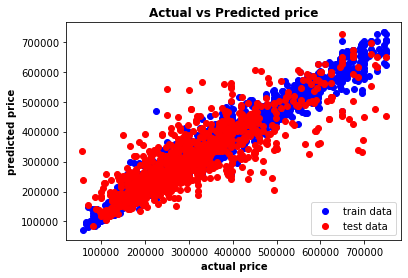

In [36]:
apartment_model = random_forest_regressor('apartment')

type of property:  house
train score: 0.944619949393409
test score 0.5903002238349773
Mean Absolute Error: 65605.92561478392
Mean Squared Error: 7964606690.683845
Root Mean Squared Error: 89244.64516531983
the actual house price of the test data [369900. 199000. 395000. ... 369900. 249000. 229000.]
the predicted house prices for the test data [392846.995  238374.965  374211.75   ... 489827.7625 292318.75
 191648.91  ]


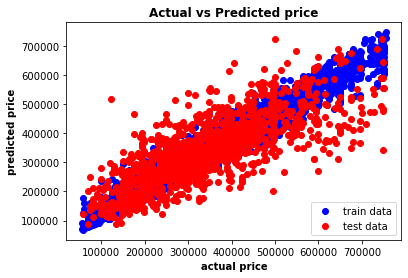

In [37]:
house_model = random_forest_regressor('house')